The aim of this notebook is to document my understanding of the transformer architecture. 

In [1]:
! pip install tensorflow==2.8.2
!pip install tensorflow_datasets
!pip install -U 'tensorflow-text==2.8.*'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.9/497.9 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 37.8 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 61.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 32.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: protobuf
    Found exist

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_text
import tensorflow_datasets as tfds
from tensorflow import keras

In [3]:
tf.__version__

'2.8.2'

# Implementation of The Transformer Architecture From Scratch

In this first part of the notebook, there'll be an implementation of the transformer architecture from scratch using TensorFlow.

Heavy inspiration - https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/tensorflow/transformer.ipynb#scrollTo=s_qNSzzyaCbD

In [4]:
# check if GPU is used
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f"Found GPU device at {device_name}")

Found GPU device at /device:GPU:0


Let's start by implementing the several pieces the Transformer architecture need

### Positional Encoding

Since the Transformer architecture does not rely on convolution like CNNs or rely on early-states like the LSTMs, it needs to have its own mechanism of knowing the relative position of the tokens. This is done below

In [5]:
def get_angles(pos, i, d_model):
    """Function to compute the angles to embed positional encoding to the tokens to be fed to the transformer"""
    
    angle_rates = 1/np.power(10000, (2*(i //2)) / np.float32(d_model))
    return pos * angle_rates

In [6]:
# check if the function works as intended
get_angles(10000, 5, 512)

9305.72040929699

In [7]:
def positional_encoding(position, d_model):
    """Embeds the tokens to be fed into the transformer with a positional encoding
    Computes a sin and cos of the angles returned by the get_angles() function
    and adds the value to an axis of the tokens
    """
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], 
                           np.arange(d_model)[np.newaxis, :], d_model)
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # apply cos to odd indices in the array; 2i + 1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [8]:
# check if the code works as intended
pos_encoding = positional_encoding(50, 512)
pos_encoding

<tf.Tensor: shape=(1, 50, 512), dtype=float32, numpy=
array([[[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
        [ 8.41470957e-01,  5.40302277e-01,  8.21856201e-01, ...,
          1.00000000e+00,  1.03663289e-04,  1.00000000e+00],
        [ 9.09297407e-01, -4.16146845e-01,  9.36414719e-01, ...,
          1.00000000e+00,  2.07326579e-04,  1.00000000e+00],
        ...,
        [ 1.23573124e-01, -9.92335498e-01,  9.77189839e-01, ...,
          9.99987245e-01,  4.87215538e-03,  9.99988139e-01],
        [-7.68254638e-01, -6.40144348e-01,  7.31235921e-01, ...,
          9.99986708e-01,  4.97581763e-03,  9.99987602e-01],
        [-9.53752637e-01,  3.00592542e-01, -1.44026920e-01, ...,
          9.99986112e-01,  5.07947942e-03,  9.99987125e-01]]],
      dtype=float32)>

In [9]:
pos_encoding.shape

TensorShape([1, 50, 512])

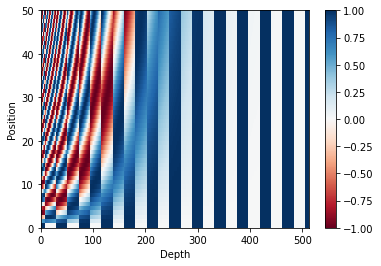

In [10]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Attention

In [11]:
def scaled_dot_product_attention(q, k, v, mask):
    """Computes the attention weights
    
    q, k, v must have matching leading dimensions
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    
    q - query vectors; shape == (..., seq_len_q, depth)
    k - key vectors; shape == (..., seq_len_k, depth)
    v - value vectors; shape == (..., seq_len_v, depth_v)
    
    It is called self-attention because these three vectors are gotten from the same source
    
    Returns attention weights, output
    """
    
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    dk = tf.cast(tf.shape(k)[-1], dtype=tf.float32)
    scaled_dk = tf.math.sqrt(dk)
    
    scaled_attention_logits = matmul_qk/scaled_dk
    
    # add mask
    if mask is not None:
        scaled_attention_logits += (mask*-1e9)
    
    # softmax the attention weights so that it adds up to 1
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

In [12]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('\nOutput is:')
    print(temp_out)

In [13]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32) # (4, 2)

temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)
                     
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)

Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


### Multi-Head Attention

In [14]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """Computes the attention for several heads in the transformer"""
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        
        assert d_model % num_heads == 0 # ensure the dimension can be split evenly
        
        self.depth = self.d_model // self.num_heads
        
        self.wk = tf.keras.layers.Dense(d_model)
        self.wq = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth)
         Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        # Dense models on the v, k, q vectors
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        # split the heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # compute attention weights
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # (batch_size, seq_len_q, num_heads, depth)
        
        # reshape and add Dense layer
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention) #(batch_size, seq_len_q, d_model)
        
        return output, attention_weights

In [15]:
# let's check if this works as intended
temp_multihead = MultiHeadAttention(512, 8)

y = tf.random.uniform((1, 60, 512))
out, attn = temp_multihead(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point-Wise Feed Forward Network

In [16]:
def pointwise_feed_forward_network(d_model, dff):
    model = tf.keras.Sequential([tf.keras.layers.Dense(dff, activation='relu'), 
                                 tf.keras.layers.Dense(d_model)])
    return model

In [17]:
sample_ffn = pointwise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

### The Encoder Layer

In [18]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        """Initializes the Encoder Layer
        
        Args: 
             d_model - number of units for the Transformer architecture
             num_heads - number of heads for MultiHeadAttention
             dff - number of units for pointwise feedforward network
             rate - dropout rate
        """
        super(EncoderLayer, self).__init__()
        
        self.multihead = MultiHeadAttention(d_model, num_heads)
        self.ffn = pointwise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.multihead(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(ffn_output + out1)
        
        return out2

In [19]:
# test
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, mask=None)
sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

### The Decoder Layer

In [20]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.multihead1 = MultiHeadAttention(d_model, num_heads)
        self.multihead2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = pointwise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """x - query vector for the Decoder
        enc_output - the output of the top encoder is used as vectors v and k
        training - mode for Dropout
        look_ahead_mask/padding_mask- required for the masked multihead attention
        """
        attn1, attn_weights_block1 = self.multihead1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x) # becomes the query vector for the next step
        
        attn2, attn_weights_block2 = self.multihead2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2

In [21]:
# let's test this out
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)
sample_decoder_layer_output, _, _ = sample_decoder_layer(x=tf.random.uniform((64, 50, 512)), enc_output=sample_encoder_layer_output, 
                                                        training=False, look_ahead_mask=None, padding_mask=None)

sample_decoder_layer_output.shape

TensorShape([64, 50, 512])

## The Encoder

In [22]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff,rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        # add embedding and positional encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # tf.math.sqrt doesn't support int types
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

In [23]:
# let's test this
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


## The Decoder

In [24]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        self.dropout = tf.keras.layers.Dropout(rate)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(self.num_layers)]
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        # add embedding and positional encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            
            attention_weights[f"decoder_layer{i + 1}_block1"] = block1
            attention_weights[f"decoder_layer{i + 1}_block2"] = block2
            
        return x, attention_weights

In [25]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

# The Transformer

In [26]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, 
                pe_target, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights

In [27]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, enc_padding_mask=None, look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

### Masking

In [28]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # add extra dimension to add padding to the attention logits
    return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

In [29]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [30]:
def create_masks(inp, tar):
    # encoder padding mask (also necessary for 2nd attention block in the decoder)
    enc_padding_mask = create_padding_mask(inp)
        
    # dec padding mask - used in the 2nd attention block in the decoder
    dec_padding_mask = create_padding_mask(inp)
        
    # used in the first attention block
    # used to pad and mask future tokens in the tokens received by the decoder
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        
    return enc_padding_mask, combined_mask, dec_padding_mask

## Loading the Dataset

In [31]:
import tensorflow_datasets as tfds
import time

examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)

train_examples, valid_examples = examples['train'], examples['validation']

2022-07-03 02:53:31.665722: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling ted_hrlr_translate-train.tfrecord...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling ted_hrlr_translate-validation.tfrecord...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling ted_hrlr_translate-test.tfrecord...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [32]:
# let's see some of the entries in the dataset
for pt, en in train_examples.take(5):
    print("Portuguese: ", pt.numpy().decode('utf-8'))
    print("English: ", en.numpy().decode('utf-8'))
    print('\n')

Portuguese:  e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
English:  and when you improve searchability , you actually take away the one advantage of print , which is serendipity .


Portuguese:  mas e se estes fatores fossem ativos ?
English:  but what if it were active ?


Portuguese:  mas eles não tinham a curiosidade de me testar .
English:  but they did n't test for curiosity .


Portuguese:  e esta rebeldia consciente é a razão pela qual eu , como agnóstica , posso ainda ter fé .
English:  and this conscious defiance is why i , as an agnostic , can still have faith .


Portuguese:  `` `` '' podem usar tudo sobre a mesa no meu corpo . ''
English:  you can use everything on the table on me .




2022-07-03 02:53:51.346371: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [33]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

196608/184801 [===============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [34]:
tokenizers = tf.saved_model.load(model_name)

In [35]:
MAX_TOKENS = 128
def filter_max_tokens(pt, en):
    num_tokens = tf.maximum(tf.shape(pt)[1],tf.shape(en)[1])
    return num_tokens < MAX_TOKENS

In [36]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [37]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

In [38]:
def make_batches(ds):
    return (ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
            .filter(filter_max_tokens).prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(valid_examples)

## Training with Keras Functional API

In [39]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

input_vocab_size = tokenizers.pt.get_vocab_size().numpy()
target_vocab_size = tokenizers.en.get_vocab_size().numpy()

In [40]:
# learning rate
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [41]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2 = 0.98, epsilon = 1e-9)

Text(0.5, 0, 'Train Step')

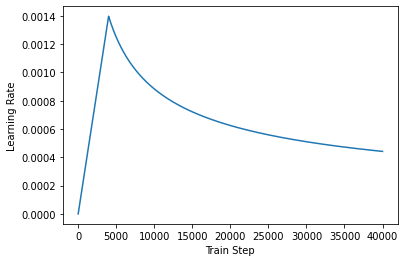

In [42]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [64]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def masked_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

metrics = [masked_loss, tf.keras.metrics.SparseCategoricalAccuracy()]

In [44]:
def build_model(input, target, num_layers = num_layers, d_model = d_model, num_heads = num_heads, 
               dff=dff, input_vocab_size = input_vocab_size, MAX_TOKENS = MAX_TOKENS, dropout_rate=dropout_rate):
    """Builds the model using Keras' Functional API"""
    
    # initiate the encoder and decoder layers
    encoder = Encoder(num_layers = num_layers, d_model=d_model, num_heads=num_heads, dff=dff, input_vocab_size=input_vocab_size, 
                      maximum_position_encoding=MAX_TOKENS, rate=dropout_rate)
    decoder = Decoder(num_layers = num_layers, d_model=d_model, num_heads=num_heads, dff=dff, target_vocab_size=target_vocab_size, 
                      maximum_position_encoding = MAX_TOKENS, rate=dropout_rate)
    
    # create the masks
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(input, target)
    
    # ops
    enc_output = encoder(input, training=True, mask=enc_padding_mask)
    dec_output, attention_weights = decoder(target, enc_output, True, combined_mask, dec_padding_mask)
    
    final_output = tf.keras.layers.Dense(target_vocab_size)(dec_output)
    model = tf.keras.models.Model(inputs=[input, target], outputs=final_output)
    
    return model

In [45]:
# define the input and target
input = tf.keras.layers.Input(shape=(None,))
target = tf.keras.layers.Input(shape=(None,))

model = build_model(input, target)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 tf.compat.v1.shape (TFOpLambda  (2,)                0           ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 tf.__operators__.getitem_2 (Sl  ()                  0           ['tf.compat.v1.shape[0][0]'] 

In [66]:
model.compile(optimizer=optimizer, loss = loss, metrics = metrics) # masked_

In [47]:
num_batches = 0
for (batch, (_,_)) in enumerate(train_batches):
    num_batches = batch
print(num_batches)

valid_batches = 0
for (batch, (_,_)) in enumerate(val_batches):
    valid_batches = batch
print(valid_batches)

700
17


In [48]:
def generator(dataset):
    while True:
        for pt_batch, en_batch in dataset:
            yield ([pt_batch , en_batch[:, :-1]], en_batch[:, 1:])

In [67]:
history = model.fit(x = generator(train_batches), validation_data = generator(val_batches), epochs=20, steps_per_epoch = num_batches, validation_steps = valid_batches)

Epoch 1/20
564/700 [=======================>......] - ETA: 15s - loss: 0.7523 - masked_loss: 2.6779 - sparse_categorical_accuracy: 0.8609

KeyboardInterrupt: 

In [50]:
def evaluate(sentence):
    
   # inp_sentence is in spanish, so add START and END tokens to it 
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
        sentence = sentence[tf.newaxis]

    sentence = tokenizers.pt.tokenize(sentence).to_tensor()
    encoder_input = sentence
    
    # As the output language is english, initialize the output with the
    # english start token.
    start_end = tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]
    
    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)
    
    for i in tf.range(MAX_TOKENS):
        output = tf.transpose(output_array.stack())
        #enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
        #predictions, attention_weights = transformer(encoder_input, output,False,enc_padding_mask,combined_mask,dec_padding_mask)
        
        predictions = model.predict([output, np.asarray([start])])
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :] # (batch_size, 1, vocab_size)
        predicted_id = tf.argmax(predictions, axis=-1)
        
        # concatentate the predicted_id to the output which is given to the decoder # as its input.
        output_array = output_array.write(i+1, predicted_id[0])
        
        # return the result if the predicted_id = end token
        if predicted_id == end:
            break
    output = tf.transpose(output_array.stack())
    text = tokenizers.en.detokenize(output)[0]
        
    return text

In [51]:
t = evaluate(tf.constant('vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'))
t

<tf.Tensor: shape=(), dtype=string, numpy=b'it it re this this s this it it this it it it re re this it it it re re re i it this this this it re now there s this this s it it this this s re this s it this it this this now this this this it this this this this this s this this this thank so this this there now this so now this s this you this it it it now it there s this it this and this this this this so this this thank i this this all s thank this thank now and thank it this this this now this all and and thank i this thank it thank and and i it there and thank'>

In [52]:
def translate(sentence, ground_truth):
    sentence = tf.constant(sentence)
    result = evaluate(sentence)
    
    print(f"Prediction: {result.numpy().decode('utf-8')}")
    print(f"Ground truth: {ground_truth}")

In [53]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'
translate(sentence, ground_truth)

Prediction: it re this this let this this it it it this it it it this it this it there it it it it this it this this this it this this it this this this it this there now it they now so this this this and it this it this this this now this this this this this this this it this this this this there it this it this there this this it this this this this this there and there this this there this there this it there this this this this this this this it and it there this this there there thank this this thank and this thank this this this there this this this this there and this it thank this and
Ground truth: this is a problem we have to solve .


## Training with TensorFlow Lower Level API

In [61]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [55]:
input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
target_vocab_size=tokenizers.en.get_vocab_size().numpy()
input_vocab_size

(7765,)

In [56]:
transformer = Transformer(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, 
                         input_vocab_size=tokenizers.pt.get_vocab_size().numpy(), target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
                          pe_input= MAX_TOKENS, pe_target = MAX_TOKENS, rate=dropout_rate)

In [57]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [58]:
EPOCHS= 20

In [62]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, 
                                     combined_mask, dec_padding_mask)
        loss = masked_loss(tar_real, predictions)
    
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [63]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 5.9414 Accuracy 0.0235
Epoch 1 Batch 50 Loss 6.0489 Accuracy 0.0233
Epoch 1 Batch 100 Loss 6.0454 Accuracy 0.0230
Epoch 1 Batch 150 Loss 6.0261 Accuracy 0.0241
Epoch 1 Batch 200 Loss 6.0129 Accuracy 0.0250
Epoch 1 Batch 250 Loss 5.9911 Accuracy 0.0271


KeyboardInterrupt: 

### Evaluation

In [ ]:
def evaluate(sentence):
    
   # inp_sentence is in spanish, so add START and END tokens to it 
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
        sentence = sentence[tf.newaxis]

    sentence = tokenizers.pt.tokenize(sentence).to_tensor()
    encoder_input = sentence
    
    # As the output language is english, initialize the output with the
    # english start token.
    start_end = tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]
    
    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)
    
    for i in tf.range(MAX_TOKENS):
        output = tf.transpose(output_array.stack())
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
        predictions, attention_weights = transformer(encoder_input, output,False,enc_padding_mask,combined_mask,dec_padding_mask)
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :] # (batch_size, 1, vocab_size)
        predicted_id = tf.argmax(predictions, axis=-1)
        
        # concatentate the predicted_id to the output which is given to the decoder # as its input.
        output_array = output_array.write(i+1, predicted_id[0])
        
        # return the result if the predicted_id = end token
        if predicted_id == end:
            break
    output = tf.transpose(output_array.stack())
    text = tokenizers.en.detokenize(output)[0]
        
    return text

In [ ]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'
translate(sentence, ground_truth)